In [1]:
import wandb
wandb.login()

wandb: Currently logged in as: nsshevtsov. Use `wandb login --relogin` to force relogin


True

In [2]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
from datasets import load_dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor
from transformers import LayoutLMv2ForTokenClassification, TrainingArguments, Trainer
from datasets import load_metric
import numpy as np

from scripts.preprocess_utils import prepare_pic


In [3]:
!nvidia-smi

Mon May 20 10:01:08 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   41C    P0    70W / 300W |      3MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   

In [4]:
dataset = {}
dataset['train'], dataset['test'] = load_dataset('datasets/invoices_limited_55/funsd.py',  split=['train[:15]', 'test'])
#dataset['train'], dataset['test'] = load_dataset('datasets/passports/passports_all_doctr.py',  split=['train[:15]', 'test'])

/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/datasets/load.py:922: FutureWarning: The repository for funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at datasets/invoices_limited_55/funsd.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
feature_extractor = LayoutLMv2FeatureExtractor(ocr_lang="rus", apply_ocr=False, do_resize=True, size=224)  # apply_ocr is set to True by default
tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [6]:
tokenizer.tokenize("hello world! привет мир!")

['hello',
 'world',
 '!',
 'п',
 '##р',
 '##и',
 '##в',
 '##е',
 '##т',
 'м',
 '##и',
 '##р',
 '!']

In [7]:
labels = ['Банк получателя', 'Получатель', 'БИК банка получателя', 'Счет банка', 'Счет получателя', 'Всего к оплате', 'Поставщик', 'Покупатель', 'Остальное', 'Номер счета', 'Дата', 'ИНН получателя', 'КПП получателя']
#labels = ['issued', 'issued_date', 'code', 'number', 'lastname', 'firstname', 'middlename', 'gender', 'bday', 'place', 'other']
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

In [8]:
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
})

def preprocess_data(examples):
    images = [Image.open(path).convert('RGB') for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']
    word_labels = examples['ner_tags']
    encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                             padding="max_length", truncation=True)
    # encoded_inputs['image'] = np.ones((len(images), 3, 224, 224)).astype(int).tolist()
    return encoded_inputs

train_dataset = dataset['train'].map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names,
                                      features=features)
test_dataset = dataset['test'].map(preprocess_data, batched=True, remove_columns=dataset['test'].column_names,
                                      features=features)

In [9]:
len(train_dataset[0]['input_ids'])

512

In [10]:
example = dataset["train"][0]
print(example.keys())

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])


In [11]:
from torch.utils.data import DataLoader

train_dataset.set_format(type="torch")
test_dataset.set_format(type="torch")
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, pin_memory=False)

In [12]:
from transformers import LayoutLMv2Config

#config = LayoutLMv2Config(max_position_embeddings=512, num_labels=len(labels))
model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-large-uncased', num_labels=len(labels))

''' 
for param in model.parameters():
    param.requires_grad = False

k = 0
for param in model.parameters():
    if k > 150:
        param.requires_grad = True
    k += 1
'''
# Set id2label and label2id
model.config.id2label = id2label
model.config.label2id = label2id

# Metrics
metric = load_metric("seqeval")
return_entity_level_metrics = True


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }


class RusFunsdTrainer(Trainer):
    def get_train_dataloader(self):
        return train_dataloader

    def get_eval_dataloader(self, test_dataset):
        return test_dataloader


args = TrainingArguments(
    output_dir="run",  # name of directory to store the checkpoints
    num_train_epochs=100,
    warmup_ratio=0.1,
    # warmup_steps=0,
    learning_rate=3e-5,
    lr_scheduler_type ='cosine',
    
    evaluation_strategy="epoch",
    save_strategy='epoch',
    logging_strategy='epoch',
    load_best_model_at_end=True,
    
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    
    metric_for_best_model='overall_f1',
    
    seed=88
)

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
    eval_dataset=test_dataset,
    train_dataset=train_dataset,
)

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1199164/3945091801.py:21: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True

In [13]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

425580045

In [14]:
mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
mem = mem_params + mem_bufs # in bytes
mem / 1024 / 1024 / 1024  # in GB

1.5885084383189678

In [15]:
wandb.init(project="invoices_limited",
           config=dict())

Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    self.run()
  File "/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 300, in check_internal_messages
    self._target(*self._args, **self._kwargs)
  File "/home/dedoc/.virtualenvs/forms/lib/python

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Ик банка получателя Precision,Ик банка получателя Recall,Ик банка получателя F1,Ик банка получателя Number,Нн получателя Precision,Нн получателя Recall,Нн получателя F1,Нн получателя Number,Пп получателя Precision,Пп получателя Recall,Пп получателя F1,Пп получателя Number,Анк получателя Precision,Анк получателя Recall,Анк получателя F1,Анк получателя Number,Ата Precision,Ата Recall,Ата F1,Ата Number,Окупатель Precision,Окупатель Recall,Окупатель F1,Окупатель Number,Олучатель Precision,Олучатель Recall,Олучатель F1,Олучатель Number,Омер счета Precision,Омер счета Recall,Омер счета F1,Омер счета Number,Оставщик Precision,Оставщик Recall,Оставщик F1,Оставщик Number,Сего к оплате Precision,Сего к оплате Recall,Сего к оплате F1,Сего к оплате Number,Стальное Precision,Стальное Recall,Стальное F1,Стальное Number,Чет банка Precision,Чет банка Recall,Чет банка F1,Чет банка Number,Чет получателя Precision,Чет получателя Recall,Чет получателя F1,Чет получателя Number,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,3.043000,2.700879,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,6,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,10,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,8,0.009901,0.400000,0.019324,5,0.000000,0.000000,0.000000,86,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.003317,0.010811,0.005076,0.022976
2,2.384300,1.730952,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,6,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,10,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,5,0.089888,0.093023,0.091429,86,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.040000,0.043243,0.041558,0.542670
3,1.735600,1.489990,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,6,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,10,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,5,0.000000,0.000000,0.000000,86,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,0.589716
4,1.539500,1.394577,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,6,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,10,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,5,0.000000,0.000000,0.000000,86,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,0.597374
5,1.482600,1.331676,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,6,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,10,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,5,0.151899,0.139535,0.145455,86,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.080537,0.064865,0.071856,0.617068
6,1.317000,1.190088,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,6,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,10,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,5,0.175000,0.162791,0.168675,86,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.089744,0.075676,0.082111,0.621444
7,1.126500,0.954335,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,6,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,10,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,8,0.000000,0.000000,0.000000,5,0.274725,0.

/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Остальное seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Банк получателя seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: БИК банка получателя seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Счет банка seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ИНН получателя seems not to be 

SafetensorError: Error while serializing: IoError(Os { code: 28, kind: StorageFull, message: "No space left on device" })

In [ ]:
trainer.save_model("weights/last_run_best")

In [ ]:
model

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap
    self._bootstrap_inner()
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/concurrent/futures/thread.py", line 83, in _worker
    work_item.run()
  File "/usr/lib/python3.10/concurrent/futures/thread.py", line 58, in run
    result = self.fn(*self.args, **self.kwargs)
  File "/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/wandb/filesync/step_upload.py", line 288, in run_and_notify
    self._do_upload_sync(event)
  File "/home/dedoc/.virtualenvs/fo


## Test

In [16]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
from datasets import load_dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor
from transformers import LayoutLMv2ForTokenClassification, TrainingArguments, Trainer
from datasets import load_metric
import numpy as np

from scripts.preprocess_utils import prepare_pic

In [32]:
from utils.LayoutLMv2DoctrFeatureExctractor import LayoutLMv2DoctrFeatureExtractor
import cv2

#labels = ['Банк получателя', 'Получатель', 'БИК банка получателя', 'Счет банка', 'Счет получателя', 'Всего к оплате', 'Поставщик', 'Покупатель', 'Остальное', 'Номер счета', 'Дата', 'ИНН получателя', 'КПП получателя']
labels = ['issued', 'issued_date', 'code', 'number', 'lastname', 'firstname', 
                                   'middlename', 'gender', 'bday', 'place', 'other']
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

# feature_extractor = LayoutLMv2FeatureExtractor(ocr_lang="rus", prepare_pic=None)  # apply_ocr is set to True by default
feature_extractor = LayoutLMv2DoctrFeatureExtractor()
tokenizer = LayoutLMv2TokenizerFast.from_pretrained('microsoft/layoutlmv2-base-uncased') # "vocab.txt")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)
model = LayoutLMv2ForTokenClassification.from_pretrained('weights/devoted-grass-16', num_labels=len(labels))

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]
    
def visualize_predict(path, model):
    # image = prepare_pic(path, 'preprocessing_templates').convert('RGB')
    image = Image.open(path).convert('RGB')
    encoded_inputs = processor(image, padding="max_length", truncation=True, return_tensors="pt")
    model.eval()
    outputs = model(**encoded_inputs)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoded_inputs.bbox.squeeze().tolist()
    width, height = image.size
    true_predictions = [id2label[prediction] for prediction in predictions]
    true_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
    texts = tokenizer.batch_decode(encoded_inputs['input_ids'])[0]
    result = {}
    image = np.array(image)
    for prediction, box, text in zip(true_predictions, true_boxes, texts):
        x1, y1, x2, y2 = [int(b) for b in box]
        predicted_label = prediction.lower()
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (36,255,12), 1)
        cv2.putText(image, predicted_label, (x1, y1-2), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,33,33), 1)

        if predicted_label != 'остальное':
            if predicted_label in result:
                result[predicted_label] += f' {text}'
            else:
                result[predicted_label] = text

    return image, result

imgs = []
ds_dir = 'datasets/passports'
for img_name in os.listdir(f'{ds_dir}/test/')[:10]:
    imgs.append(visualize_predict(f'{ds_dir}/test/' + img_name, model))

/home/dedoc/.virtualenvs/forms/lib/python3.10/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


datasets/passports/test/0279.jpg
datasets/passports/test/0207.jpg
datasets/passports/test/0035.jpg
datasets/passports/test/0014.jpg


KeyboardInterrupt: 

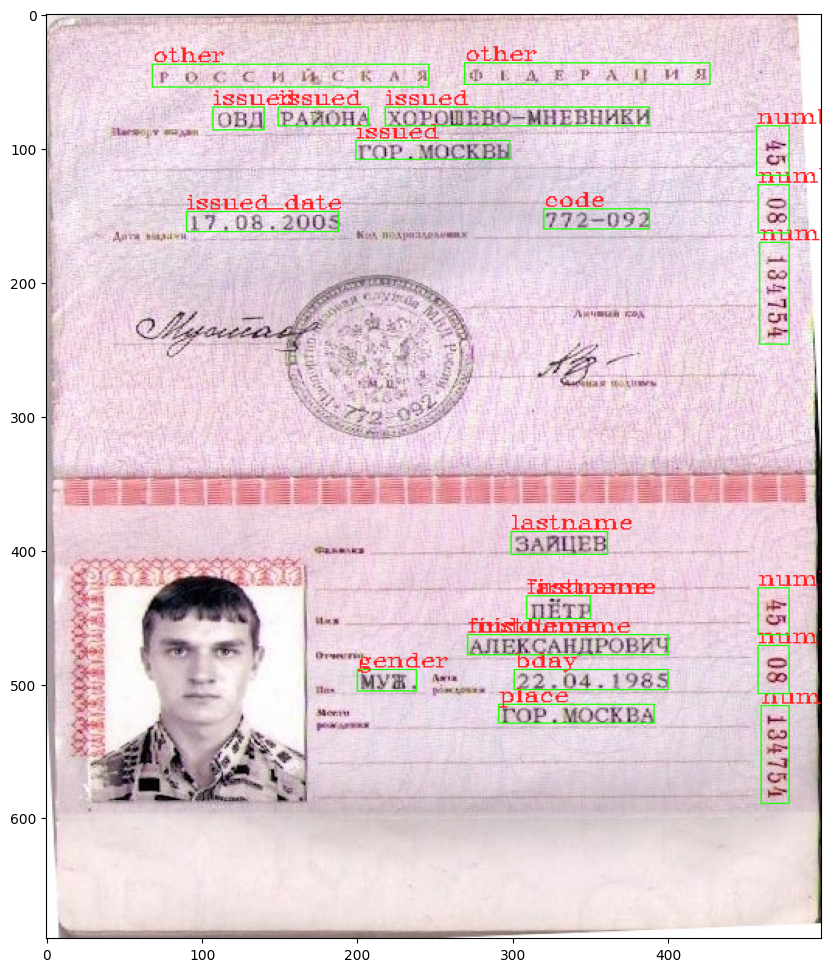

In [18]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,12))
plt.imshow(imgs[6][0], aspect='auto')

In [19]:
imgs[5][1]

{'issued': '[ и л ь я   н   ©   р у х о в   5   с о   с о   с л   5 0 0   -   1 0 9   2   0 1 .   2 0 0 8  ',
 'place': 'C L S ]   г о р .',
 'number': '  р я з а н ь   1 0 8 7   в л а д   8 .',
 'gender': '<   с о',
 'bday': '  с о   2',
 'middlename': '  с л   м у ж .',
 'firstname': '  0 1',
 'lastname': '.   .   1 9',
 'code': 'и м и',
 'issued_date': 'р о в и ч',
 'other': '-   о з е р с к о м   р   -   н е   в   м о с к о в с к о и   р о с с и и   о б л .   у ф м с   п о   -   8 5   о т д е л е н и е м   ф е д е р а ц и я   р о с с и и с к а я   [ S E P ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ]   [ P A D ] 

## Time test

In [39]:
type(encoded_inputs)

transformers.tokenization_utils_base.BatchEncoding

In [47]:
model = LayoutLMv2ForTokenClassification.from_pretrained('weights/chocolate-capybara-48')

path = 'datasets/passports/test/0279.jpg'
image = Image.open(path).convert('RGB')
encoded_inputs = processor(image, padding="max_length", truncation=True, return_tensors="pt")
model.eval()
outputs = model(**encoded_inputs)

In [48]:
%%timeit -n 20
outputs = model(**encoded_inputs)

308 ms ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)
